# Отгадай писателя ужастиков

### Мороз Денис Анатольевич (@denismoroz)

Данный проект базируется на соревновании Kaggle по угадыванию вероятностей принадлежности фрагмента текста одному из трех писателей рассказов ужасов https://www.kaggle.com/c/spooky-author-identification. 



Даны размеченные данные с тремя признаками: 
id - номер фрагмента текста; 
text - фрагмент текста
author - автор фрагмента (целевая переменная).

In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

Подтянем базы данных и ознакомимся с их структурой.

In [2]:
train_texts = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')
sample_sub= pd.read_csv('../../data/sample_submission.csv')

In [3]:
train_texts.info(())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
id      8392 non-null object
text    8392 non-null object
dtypes: object(2)
memory usage: 131.2+ KB


In [6]:
train_texts.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [8]:
sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 4 columns):
id     8392 non-null object
EAP    8392 non-null float64
HPL    8392 non-null float64
MWS    8392 non-null float64
dtypes: float64(3), object(1)
memory usage: 262.3+ KB


In [9]:
sample_sub.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


Ознакомимся с данными. Построим на графике количество фрагментов текста по каждому автору в тестовой выборке. В целевой переменной у нас всего три автора и фрагменты распределены плюс минус равномерно. Как видим, это задача мультиклассовой классификации с тремя целевыми признаками.

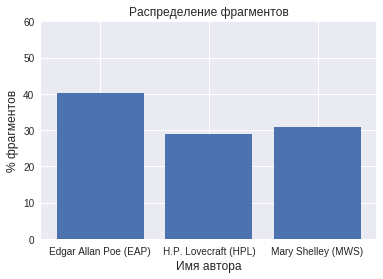

In [10]:
num_total = len(train_texts)
num_eap = len(train_texts.loc[train_texts.author == 'EAP'])
num_hpl = len(train_texts.loc[train_texts.author == 'HPL'])
num_mws = len(train_texts.loc[train_texts.author == 'MWS'])

fig, ax = plt.subplots()
eap, hpl, mws = plt.bar(np.arange(1, 4), [(num_eap/num_total)*100, (num_hpl/num_total)*100, (num_mws/num_total)*100])
ax.set_xticks(np.arange(1, 4))
ax.set_xticklabels(['Edgar Allan Poe (EAP)', 'H.P. Lovecraft (HPL)', 'Mary Shelley (MWS)'])
ax.set_ylim([0, 60])
ax.set_ylabel('% фрагментов', fontsize=12)
ax.set_xlabel('Имя автора', fontsize=12)
ax.set_title('Распределение фрагментов')
plt.show()

Вполне очевидно, что каждого автора отличает определенный лексический запас и на этом в первую очередь необходимо базироваться при построении обучающейся модели. Напишем функцию, которая выводит 
матрицу общих пар слов больше трех символов (или комбинации из двух слов) для пар авторов.  

In [12]:
def common_words_matrix(df):  
    columns=["words","author"]
    words_pool=pd.DataFrame(columns=columns)
    for t in tqdm(range(len(df))):
        words=re.findall('\w{3,}', df["text"].iloc[t].lower())
        words = [' '.join(ws) for ws in zip(words, words[1:])]
        
        for word in words:
            words_pool.loc[words_pool.shape[0]]=[word,df["author"].iloc[t]]
    
    cross=pd.crosstab(words_pool.words,words_pool.author)
    columns_m=["EAP","HPL","MWS"]
    index_m=["EAP","HPL","MWS"]
    matrix=pd.DataFrame(columns=columns_m,index=index_m)
    matrix.loc["EAP","EAP"]=len(cross.loc[cross.EAP==1])
    matrix.loc["HPL","HPL"]=len(cross.loc[cross.HPL==1])
    matrix.loc["MWS","MWS"]=len(cross.loc[cross.MWS==1])
    matrix.loc["EAP","HPL"]=len(cross.loc[(cross.EAP==1) & (cross.HPL==1)])
    matrix.loc["HPL","EAP"]=len(cross.loc[(cross.EAP==1) & (cross.HPL==1)])
    matrix.loc["EAP","MWS"]=len(cross.loc[(cross.EAP==1) & (cross.MWS==1)])
    matrix.loc["MWS","EAP"]=len(cross.loc[(cross.EAP==1) & (cross.MWS==1)])
    matrix.loc["HPL","MWS"]=len(cross.loc[(cross.HPL==1) & (cross.MWS==1)])
    matrix.loc["MWS","HPL"]=len(cross.loc[(cross.HPL==1) & (cross.MWS==1)])
    print("Количество общих слов (комбинаций слов)")
    print(matrix)

Запустим функцию common_words_matrix, чтобы увидеть сколько общих пар слов, которые 
идут подряд, используют авторы.

In [ ]:
%%time
common_words_matrix(train_texts)

 52%|█████▏    | 10220/19579 [3:10:59<986:23:58, 379.42s/it]

Из полученных матриц мы видим, что количество общих пар слов не так уж велико, это может характеризовать некую уникальность каждого автора и на этом можно базироваться, подбирая признаки для модели. Комбинации из трех и более пар слов считаю использовать нецелесообразно, т.к. модель может переобучиться. Фрагменты текстов относительно коротки и априори маловероятно, что те же тройки слов, которые встречались в тренировочной выборке станут попадаться в тестовых выборках.

Для решения данной задачи классификации я решил использовать инструмент Vowpal Wabbit (VW), который имеет следующие преимущества:

- хорошая скорость обучение модели и прогнозирования; 

- возможность использования нелинейных признаков (посредством ngram);

- удобная настройка параметров;

- встроенная кросс-валидация.

Самое главное достоинство - это удобное разбиение признакового пространства слов на пары - свойства, которое я собираюсь использовать для обучения модели и предстказания.

Закодируем буквенные символы авторов с помощью цифр 1,2,3, т.к. многоклассовая классификация VW принимает на вход только цифры.

In [25]:
d = {"EAP":1,"MWS":2,"HPL":3}

In [28]:
train_texts["author_code"]=train_texts["author"].map(d)

In [29]:
train_texts.head()

,id,text,author,author_code
0,id26305,"This process, however, afforded me no means of...",EAP,1
1,id17569,It never once occurred to me that the fumbling...,HPL,3
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,1
3,id27763,How lovely is spring As we looked from Windsor...,MWS,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,3


Напишем функцию для записи таблиц в формат VWю

In [31]:
def to_vw_format(out_vw,df,is_train=True):
    with open(out_vw,"w") as out:
        for i in range(df.shape[0]):
           
            if is_train:
                target = df["author_code"].iloc[i]
            else:
                target = 1 # в тестовой выборке target может быть любым
            text = df["text"].iloc[i].replace("\n","").replace("|","").replace(":","").lower() #удалим спецсимволы
            text = " ".join(re.findall("\w{3,}",text)) #оставим слова более 2 символов
            s = "{} |text {}\n".format(target,text)
            out.write(s)   
    

Разобьем выборку на обучающую и тестовую, % разбиения - по умолчанию.

In [32]:
train, valid = train_test_split(train_texts,random_state=13)

Посмотрим размеры выборок

In [33]:
print(train.shape[0],test.shape[0])

14684 8392


Запишем преобразованные выборки в файлы. 

In [34]:
to_vw_format("train.vw",train)

In [35]:
!head -2 train.vw

1 |text said disappointed but this not altogether the word
2 |text morrow loveliest and best hope and joy life morrow will see thee fool dream moment delay went rest


In [36]:
to_vw_format("valid.vw",valid)

In [37]:
!head -2 valid.vw

1 |text were all lions and recherchés
3 |text our studies impossible speak since they held slight connexion with anything the world living men conceive


In [38]:
to_vw_format("test.vw",test,is_train=False)

In [39]:
!head -2 test.vw

1 |text still urged our leaving ireland with such inquietude and impatience father thought best yield
1 |text fire wanted fanning could readily fanned with newspaper and the government grew weaker have doubt that leather and iron acquired durability proportion for very short time there was not pair bellows all rotterdam that ever stood need stitch required the assistance hammer


Запустим Vowpal Wabbit на сформированном файле. 

In [104]:
!rm train.vw.cache

In [105]:
!vw --oaa 3 train.vw -f model.vw -b 24 --random_seed 17 --loss_function logistic --ngram 2 --passes 30 \
--learning_rate 0.5 --power_t 0.5 -k -c -q ff

Generating 2-grams for all namespaces.
creating quadratic features for pairs: ff 
final_regressor = model.vw
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = train.vw.cache
Reading datafile = train.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
0.333333   0.333333          3      3.0          1        1        8
0.500000   0.666667          6      6.0          2        1       50
0.636364   0.800000         11     11.0          2        2       32
0.636364   0.636364         22     22.0          3        3       44
0.636364   0.636364         44     44.0          2        1       58
0.586207   0.534884         87     87.0          2        3       34
0.551724   0.517241        174    174.0          3        1       46
0.531609   0.511494        348    348.0          1        1       32
0.477011   0.422414  

Проверим на валидационной выборке.

In [106]:
%%time
!vw -i model.vw -t -d valid.vw -p valid_pred.txt --random_seed 17

only testing
Generating 2-grams for all namespaces.
Num weight bits = 24
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = valid_pred.txt
using no cache
Reading datafile = valid.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
0.000000   0.000000          3      3.0          3        3       36
0.000000   0.000000          6      6.0          1        1       16
0.090909   0.200000         11     11.0          2        2       82
0.272727   0.454545         22     22.0          1        1       14
0.204545   0.136364         44     44.0          2        3       30
0.160920   0.116279         87     87.0          3        3       46
0.166667   0.172414        174    174.0          2        2       36
0.158046   0.149425        348    348.0          1        1       46
0.183908   0.209770        696    696.0          1        1        8
0.166667   0.149425       1

В задании на Kaggle точность оценивается с помощью метрики logloss. В связи с эти в модели VW была настроена логистическая функция потерь. Кросс-валидации на тренировочной выборке дала хороший результат; average loss = 0.0139812, на валидационной выборке - 0.155669. 

Также метрикой для оценки модели на валидационной выборке может служить accuracy_score, которая широко используется на практике для оценки задач классификации. В данном случае, как видно ниже, она показывает неплохой результат для такой простой модели, как наша.

In [107]:
with open('valid_pred.txt') as pred_file:
    valid_pred = [float(label) for label in pred_file.readlines()]

In [108]:
accuracy_score(valid["author_code"], valid_pred)

0.84433094994892743

Вручную я проводил изменения параметров VW, таких как количество проходов, количество ngram, регуляризация и пр., однако они дают худший результат.

Запустим на тестовой выборке и сформируем посылку.

In [115]:
%%time
!vw -i model.vw -t -d test.vw -p test_pred.csv --random_seed 17 -r test_prob.txt

only testing
Generating 2-grams for all namespaces.
Num weight bits = 24
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = test_pred.csv
raw predictions = test_prob.txt
using no cache
Reading datafile = test.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
0.666667   0.666667          3      3.0          1        3       58
0.500000   0.333333          6      6.0          1        1       58
0.454545   0.400000         11     11.0          1        2       74
0.454545   0.454545         22     22.0          1        1       52
0.431818   0.409091         44     44.0          1        1       38
0.425287   0.418605         87     87.0          1        2       34
0.500000   0.574713        174    174.0          1        1       62
0.522989   0.545977        348    348.0          1        1       36
0.531609   0.540230        696    696.0          1        2       

In [192]:
test_prob=pd.read_csv("test_prob.txt",header=None,sep=" |:",names=["x","EAP","x","MWS","x","HPL"])

/home/denismoroz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [193]:
test_prob.head()


,x,EAP,x.1,MWS,x.2,HPL
0,1,-1.613020,2,1.70801,3,-3.331090
1,1,2.291450,2,-5.67360,3,-2.442430
2,1,-3.281310,2,-3.78668,3,2.496090
3,1,-2.032310,2,-3.41833,3,0.304634
4,1,0.879658,2,-2.16117,3,-1.481710


Используя формулу  1/(1+exp(-score)) преобразуем полученные значения вероятностей.

In [171]:
for i in ["EAP","MWS","HPL"]:
    test_prob[i] = 1/(1+np.exp(-test_prob[i])) 

In [172]:
test_prob.head()

,x,EAP,x.1,MWS,x.2,HPL
0,1,0.166170,2,0.846578,3,0.034520
1,1,0.908166,2,0.003424,3,0.079994
2,1,0.036218,2,0.022168,3,0.923867
3,1,0.115852,2,0.031727,3,0.575575
4,1,0.706751,2,0.103292,3,0.185169


Сверим размеры, полученного файла с прогнозами, и формы для посылки, скачанного с Kaggle.

In [191]:
print(test_prob.shape)
print(sample_sub.shape)

(8392, 6)
(8392, 4)


In [173]:
sample_sub.EAP=test_prob["EAP"]
sample_sub.HPL=test_prob["HPL"]
sample_sub.MWS=test_prob["MWS"]

In [183]:
sample_sub.head()

,id,EAP,HPL,MWS
0,id02310,0.166170,0.034520,0.846578
1,id24541,0.908166,0.079994,0.003424
2,id00134,0.036218,0.923867,0.022168
3,id27757,0.115852,0.575575,0.031727
4,id04081,0.706751,0.185169,0.103292


In [186]:
sample_sub.to_csv('benchmark_submission.csv',index=False)

In [187]:
bench=pd.read_csv("benchmark_submission.csv")

In [188]:
bench.head()

,id,EAP,HPL,MWS
0,id02310,0.166170,0.034520,0.846578
1,id24541,0.908166,0.079994,0.003424
2,id00134,0.036218,0.923867,0.022168
3,id27757,0.115852,0.575575,0.031727
4,id04081,0.706751,0.185169,0.103292


Посылку отправили на Kaggle. С первого раза 209 место из 519. Думаю, неплохо!

<img src="../../img/Screenshot.png">

Вывод: VW c минимальным количеством признаком дал неплохой результат, который может служить базой для дальнейших улучшений. В первую очередь необходимо добавить количество признаков, напр., количество знаков пунктуации, соотношение позитивных/негативных слов и др. Также улучшить результат позволит использование других моделей NLP, таких как word2vec.